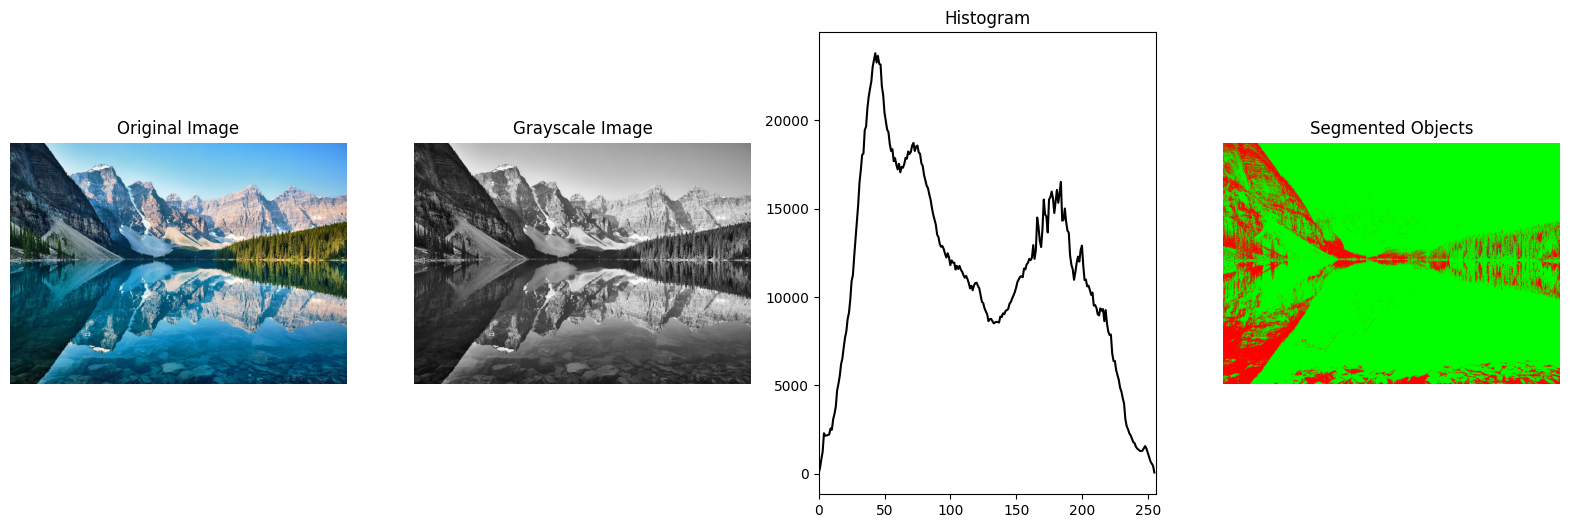

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
from scipy.signal import find_peaks
from skimage import img_as_float, io

def load_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

image_url = "https://images.unsplash.com/photo-1503614472-8c93d56e92ce?q=80&w=2011&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"
image = load_image_from_url(image_url)

gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

histogram, bins = np.histogram(gray_image, bins=256, range=[0, 256])

peaks, _ = find_peaks(histogram, prominence=100)

ranges = [(bins[peaks[i]], bins[peaks[i+1]]) for i in range(len(peaks)-1)]

segmented_img = np.zeros((gray_image.shape[0], gray_image.shape[1], 3))

region_3 = (gray_image <= ranges[0][0])
region_1 = (gray_image > ranges[0][0]) & (gray_image <= ranges[1][0])
region_2 = (gray_image > ranges[1][0])

segmented_img[region_1] = (1, 0, 0)  # Red
segmented_img[region_2] = (0, 1, 0)  # Green
segmented_img[region_3] = (0, 0, 1)  # Blue

fig, axes = plt.subplots(1, 4, figsize=(20, 6))

axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(gray_image, cmap='gray')
axes[1].set_title('Grayscale Image')
axes[1].axis('off')

axes[2].plot(bins[:-1], histogram, color='black')
axes[2].set_title('Histogram')
axes[2].set_xlim([0, 256])

axes[3].imshow(segmented_img)
axes[3].set_title('Segmented Objects')
axes[3].axis('off')

plt.show()


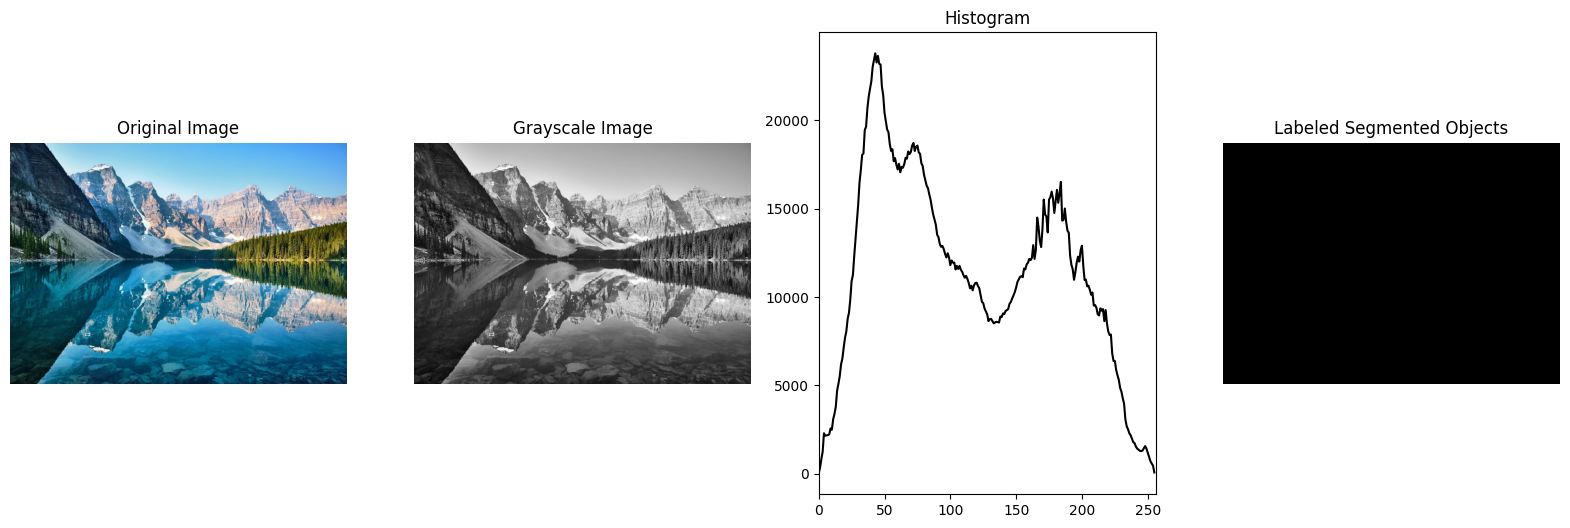

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
from scipy.signal import find_peaks
from skimage import img_as_float, io, measure

def load_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

image_url = "https://images.unsplash.com/photo-1503614472-8c93d56e92ce?q=80&w=2011&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"
image = load_image_from_url(image_url)

gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

histogram, bins = np.histogram(gray_image, bins=256, range=[0, 256])

peaks, _ = find_peaks(histogram, prominence=100)

ranges = [(bins[peaks[i]], bins[peaks[i+1]]) for i in range(len(peaks)-1)]

segmented_img = np.zeros((gray_image.shape[0], gray_image.shape[1], 3), dtype=np.uint8)

region_1 = (gray_image >= ranges[0][0]) & (gray_image <= ranges[0][1])
region_2 = (gray_image >= ranges[1][0]) & (gray_image <= ranges[1][1])
region_3 = (gray_image >= ranges[2][0]) & (gray_image <= ranges[2][1])

segmented_img[region_1] = (1, 0, 0)  # Red color for object 1
segmented_img[region_2] = (0, 1, 0)  # Green color for object 2
segmented_img[region_3] = (0, 0, 1)  # Blue color for object 3

labeled_img, num_labels = measure.label(segmented_img[:, :, 0], return_num=True)
segmented_img = np.zeros_like(segmented_img)

for i in range(1, num_labels + 1):
    segmented_img[labeled_img == i] = (i / num_labels, 0, 0)

fig, axes = plt.subplots(1, 4, figsize=(20, 6))

axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(gray_image, cmap='gray')
axes[1].set_title('Grayscale Image')
axes[1].axis('off')

axes[2].plot(bins[:-1], histogram, color='black')
axes[2].set_title('Histogram')
axes[2].set_xlim([0, 256])

axes[3].imshow(segmented_img)
axes[3].set_title('Labeled Segmented Objects')
axes[3].axis('off')

plt.show()


In [ ]:
!pip install opencv-python matplotlib



Saving image2.jpg to image2.jpg


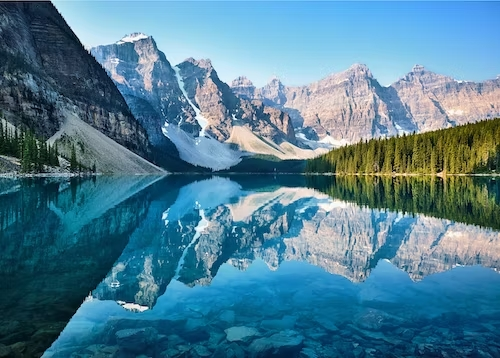

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
from google.colab import files

image_path = '/content/image1.jpg'
image = cv2.imread(image_path)

uploaded = files.upload()

net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")

classes = []
with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

layer_names = net.getLayerNames()
output_layer_indices = net.getUnconnectedOutLayers()
output_layers = [layer_names[i - 1] for i in output_layer_indices.flatten()]

height, width, _ = image.shape
blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
net.setInput(blob)
outs = net.forward(output_layers)

class_ids = []
confidences = []
boxes = []

for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)

            x = int(center_x - w / 2)
            y = int(center_y - h / 2)

            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

indices = np.argsort(confidences)[-3:]
for i in indices:
    x, y, w, h = boxes[i]
    label = str(classes[class_ids[i]])
    confidence = confidences[i]
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(image, f"{label} {confidence:.2f}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

cv2_imshow(image)


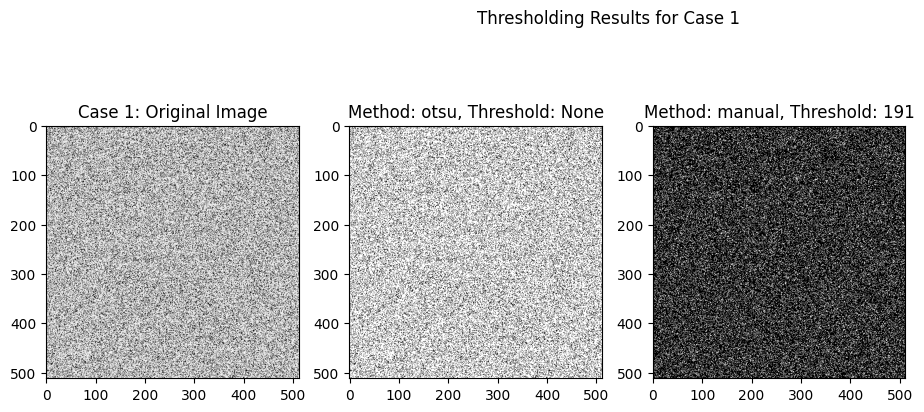

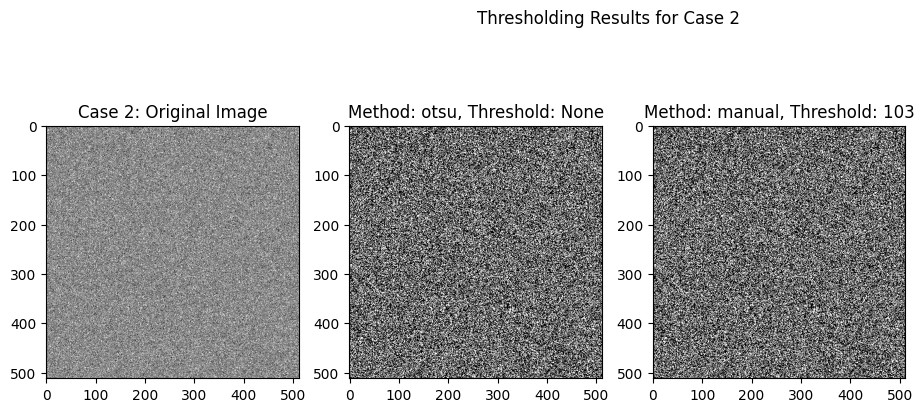

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def generate_image_two_modes():
    img = np.random.randint(0, 256, (512, 512))
    mode1 = np.random.randint(50, 150)
    mode2 = np.random.randint(150, 250)
    img[img < mode1] = np.random.randint(0, mode1)
    img[(img >= mode1) & (img < mode2)] = np.random.randint(mode1, mode2)
    img[img >= mode2] = np.random.randint(mode2, 256)
    return img.astype(np.uint8)

def generate_image_three_modes():
    img = np.random.randint(0, 256, (512, 512))
    mode1 = np.random.randint(9, 10)
    mode2 = np.random.randint(120, 190)
    mode3 = np.random.randint(210, 250)
    img[img < mode1] = np.random.randint(0, mode1)
    img[(img >= mode1) & (img < mode2)] = np.random.randint(mode1, mode2)
    img[(img >= mode2) & (img < mode3)] = np.random.randint(mode2, mode3)
    img[img >= mode3] = np.random.randint(mode3, 256)
    return img.astype(np.uint8)

def global_thresholding(img, method='otsu'):
    if img is None:
        print("Error: Unable to read the image.")
        return None, None

    if method == 'otsu':
        _, thresholded_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        best_threshold = None  # Otsu selects the best threshold automatically
    elif method == 'manual':
        hist, _ = np.histogram(img, bins=256, range=[0, 256])
        total_pixels = img.shape[0] * img.shape[1]
        probabilities = hist / total_pixels
        errors = []

        for t in range(256):
            p1 = np.sum(probabilities[:t])
            p2 = np.sum(probabilities[t:])

            if p1 == 0 or p2 == 0:
                errors.append(np.inf)
                continue

            mean1 = np.sum(np.arange(t) * probabilities[:t]) / p1
            mean2 = np.sum(np.arange(t, 256) * probabilities[t:]) / p2

            error = p1 * (mean1 - t)**2 + p2 * (mean2 - t)**2
            errors.append(error)

        best_threshold = np.argmin(errors)
        _, thresholded_img = cv2.threshold(img, best_threshold, 255, cv2.THRESH_BINARY)

    return thresholded_img, best_threshold

img_a = generate_image_two_modes()
img_b = generate_image_three_modes()

images = [img_a, img_b]
methods = ['otsu', 'manual']

for idx, img in enumerate(images, 1):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 4, 1)
    plt.title(f'Case {idx}: Original Image')
    plt.imshow(img, cmap='gray')

    for method in methods:
        thresholded_img, best_threshold = global_thresholding(img, method)
        if thresholded_img is not None:
            plt.subplot(1, 4, methods.index(method) + 2)
            plt.title(f'Method: {method}, Threshold: {best_threshold}')
            plt.imshow(thresholded_img, cmap='gray')

    plt.suptitle(f"Thresholding Results for Case {idx}")
    plt.show()


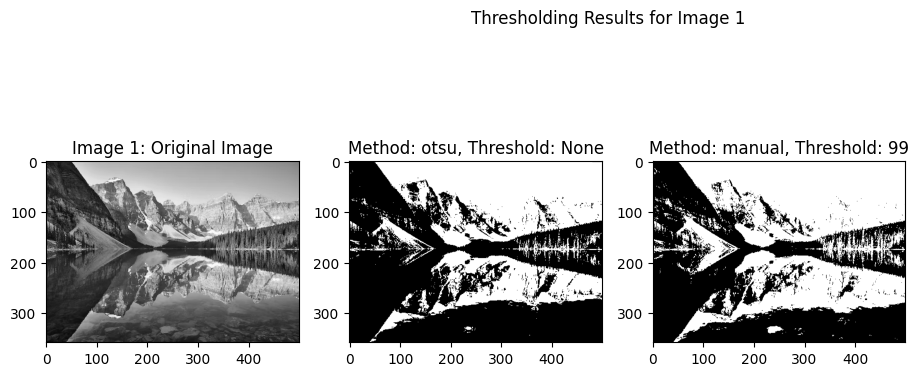

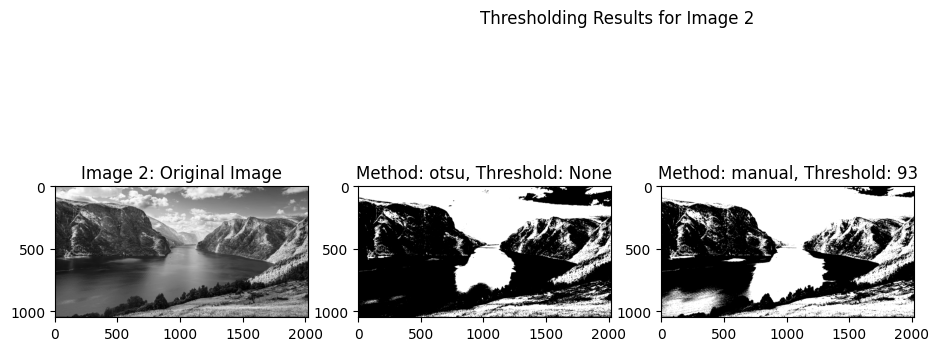

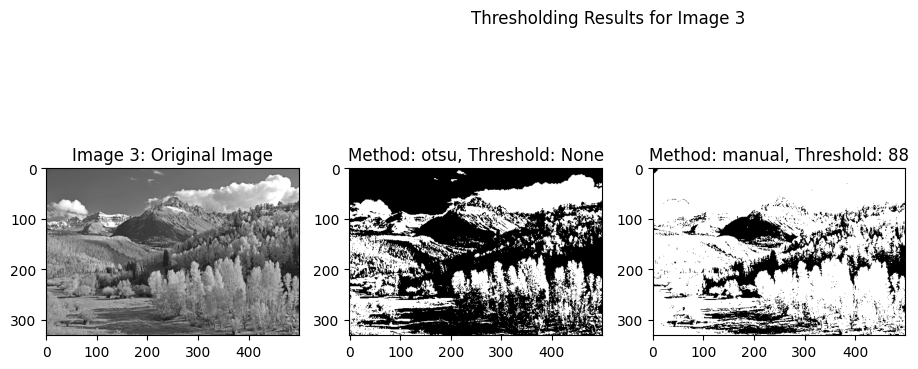

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def global_thresholding(img, method='otsu'):
    if img is None:
        print("Error: Unable to read the image.")
        return None, None

    if method == 'otsu':
        _, thresholded_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        best_threshold = None
    elif method == 'manual':
        hist, _ = np.histogram(img, bins=256, range=[50, 256])
        total_pixels = img.shape[0] * img.shape[1]
        probabilities = hist / total_pixels
        errors = []

        for t in range(256):
            p1 = np.sum(probabilities[:t])
            p2 = np.sum(probabilities[t:])

            if p1 == 0 or p2 == 0:
                errors.append(np.inf)
                continue

            mean1 = np.sum(np.arange(t) * probabilities[:t]) / p1
            mean2 = np.sum(np.arange(t, 256) * probabilities[t:]) / p2

            error = p1 * (mean1 - t)**2 + p2 * (mean2 - t)**2
            errors.append(error)

        best_threshold = np.argmin(errors)
        _, thresholded_img = cv2.threshold(img, best_threshold, 255, cv2.THRESH_BINARY)

    return thresholded_img, best_threshold

image_paths = ['image1.jpg', 'image2.jpg', 'image3.jpg']
images = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in image_paths]

methods = ['otsu', 'manual']

for idx, img in enumerate(images, 1):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 4, 1)
    plt.title(f'Image {idx}: Original Image')
    plt.imshow(img, cmap='gray')

    for method in methods:
        thresholded_img, best_threshold = global_thresholding(img, method)
        if thresholded_img is not None:
            plt.subplot(1, 4, methods.index(method) + 2)
            plt.title(f'Method: {method}, Threshold: {best_threshold}')
            plt.imshow(thresholded_img, cmap='gray')

    plt.suptitle(f"Thresholding Results for Image {idx}")
    plt.show()


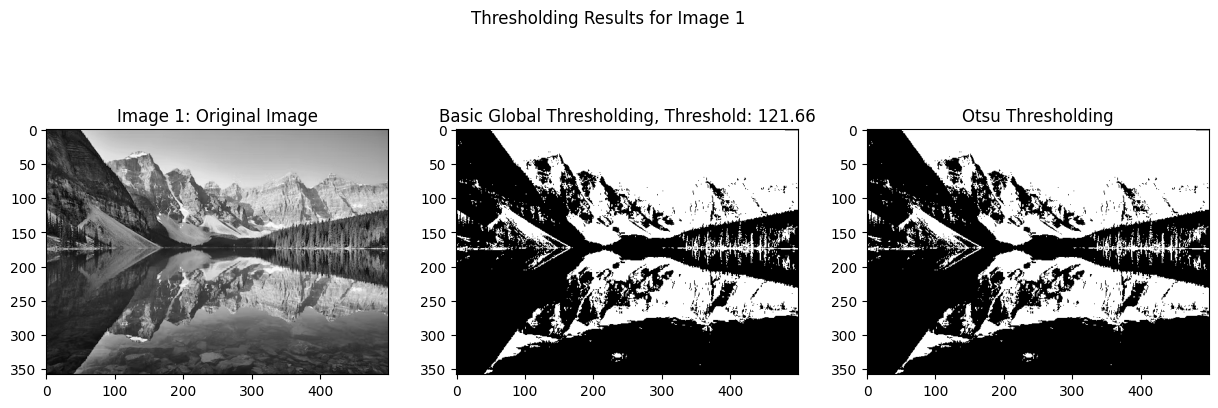

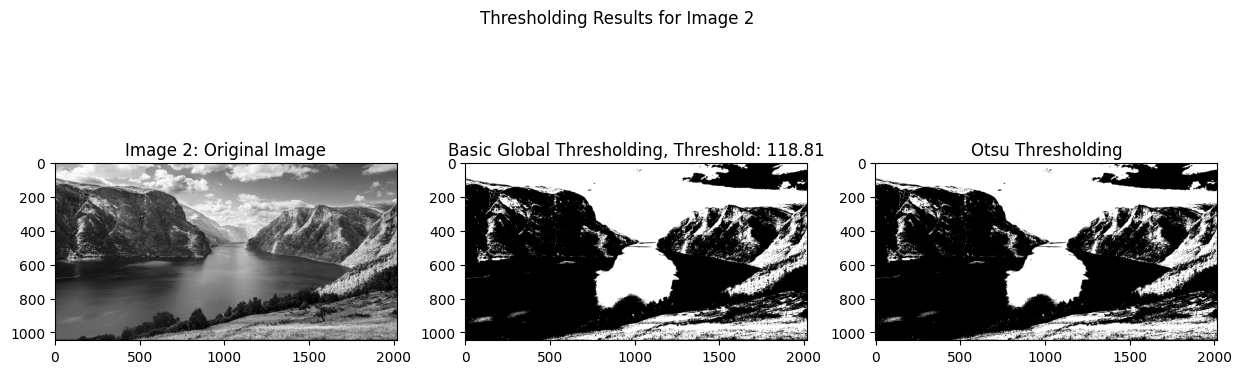

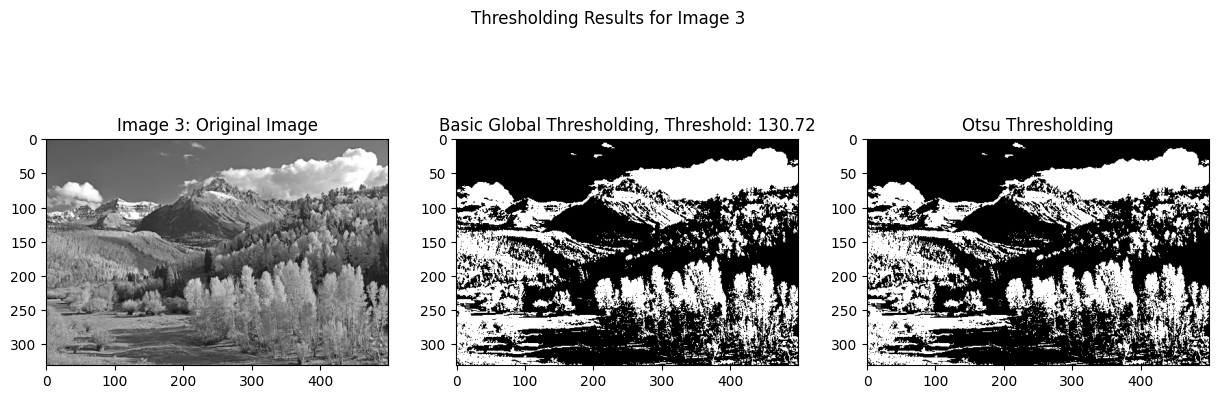

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def basic_global_thresholding(img, initial_threshold=None, max_iterations=100, tolerance=1e-5):
    if img is None:
        print("Error: Unable to read the image.")
        return None, None

    # Step 1: Select an initial estimate for T
    if initial_threshold is None:
        initial_threshold = np.mean(img)

    threshold = initial_threshold
    prev_threshold = 0
    iterations = 0

    while True:
        # Step 2: Segment the image using T
        G1 = img[img > threshold]
        G2 = img[img <= threshold]

        # Step 3: Compute the average grey levels
        μ1 = np.mean(G1) if G1.size > 0 else 0
        μ2 = np.mean(G2) if G2.size > 0 else 0

        # Step 4: Compute a new threshold value
        new_threshold = (μ1 + μ2) / 2

        # Step 5: Check convergence
        if np.abs(new_threshold - threshold) < tolerance or iterations >= max_iterations:
            break

        prev_threshold = threshold
        threshold = new_threshold
        iterations += 1

    thresholded_img = np.where(img > threshold, 255, 0).astype(np.uint8)

    return thresholded_img, threshold

# Read images
image_paths = ['image1.jpg', 'image2.jpg', 'image3.jpg']
images = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in image_paths]

for idx, img in enumerate(images, 1):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title(f'Image {idx}: Original Image')
    plt.imshow(img, cmap='gray')

    thresholded_img, best_threshold = basic_global_thresholding(img)
    plt.subplot(1, 3, 2)
    plt.title(f'Basic Global Thresholding, Threshold: {best_threshold:.2f}')
    plt.imshow(thresholded_img, cmap='gray')

    _, thresholded_img_otsu = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    plt.subplot(1, 3, 3)
    plt.title('Otsu Thresholding')
    plt.imshow(thresholded_img_otsu, cmap='gray')

    plt.suptitle(f"Thresholding Results for Image {idx}")
    plt.show()


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def basic_global_thresholding(img, initial_threshold=None, max_iterations=100, tolerance=1e-5):
    if img is None:
        print("Error: Unable to read the image.")
        return None, None

    if initial_threshold is None:
        initial_threshold = np.mean(img)

    threshold = initial_threshold
    prev_threshold = 0
    iterations = 0

    while True:
        G1 = img[img > threshold]
        G2 = img[img <= threshold]

        μ1 = np.mean(G1) if G1.size > 0 else 0
        μ2 = np.mean(G2) if G2.size > 0 else 0

        new_threshold = (μ1 + μ2) / 2

        if np.abs(new_threshold - threshold) < tolerance or iterations >= max_iterations:
            break

        prev_threshold = threshold
        threshold = new_threshold
        iterations += 1

    thresholded_img = np.where(img > threshold, 255, 0).astype(np.uint8)

    return thresholded_img, threshold

def multi_level_thresholding(img, num_thresholds):
    thresholds = np.linspace(0, 255, num_thresholds + 2)[1:-1]
    thresholded_img = np.zeros_like(img)

    for i in range(num_thresholds):
        lower = thresholds[i]
        upper = thresholds[i + 1] if i < num_thresholds - 1 else 255

        mask = (img > lower) & (img <= upper)
        thresholded_img[mask] = (i + 1) * (255 / num_thresholds)

    return thresholded_img.astype(np.uint8)

def adaptive_thresholding(img, block_size=3, c=2):
    thresholded_img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, c)
    return thresholded_img

image_paths = ['image1.jpg', 'image2.jpg', 'image3.jpg']
images = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in image_paths]

initial_thresholds = [100, 150, 200]
num_thresholds = [3, 5, 7]

for idx, img in enumerate(images, 1):
    plt.figure(figsize=(20, 6))

    plt.subplot(1, 3, 1)
    plt.title(f'Image {idx}: Original Image')
    plt.imshow(img, cmap='gray')

    for i, initial_threshold in enumerate(initial_thresholds):
        thresholded_img_basic, best_threshold_basic = basic_global_thresholding(img, initial_threshold)
        plt.subplot(1, 3, i + 2 if i < 2 else 3)
        plt.title(f'Basic Global\nInitial T: {initial_threshold}\nT: {best_threshold_basic:.2f}')
        plt.imshow(thresholded_img_basic, cmap='gray')

    plt.suptitle(f"Thresholding Results for Image {idx}")
    plt.show()

    plt.figure(figsize=(20, 6))

    plt.subplot(1, 3, 1)
    plt.title(f'Image {idx}: Original Image')
    plt.imshow(img, cmap='gray')

    for i, num_thresh in enumerate(num_thresholds):
        thresholded_img_multi = multi_level_thresholding(img, num_thresh)
        plt.subplot(1, 3, i + 2 if i < 2 else 3)
        plt.title(f'Multi-level\nNum Thresholds: {num_thresh}')
        plt.imshow(thresholded_img_multi, cmap='gray')

    plt.suptitle(f"Multi-level Thresholding Results for Image {idx}")
    plt.show()

    plt.figure(figsize=(20, 6))

    plt.subplot(1, 2, 1)
    plt.title(f'Image {idx}: Original Image')
    plt.imshow(img, cmap='gray')

    plt.subplot(1, 2, 2)
    plt.title('Adaptive Thresholding')
    thresholded_img_adaptive = adaptive_thresholding(img)
    plt.imshow(thresholded_img_adaptive, cmap='gray')

    plt.suptitle(f"Adaptive Thresholding Results for Image {idx}")
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def basic_global_thresholding(img, initial_threshold=None, max_iterations=100, tolerance=1e-5):
    if img is None:
        print("Error: Unable to read the image.")
        return None, None

    if initial_threshold is None:
        initial_threshold = np.mean(img)

    threshold = initial_threshold
    prev_threshold = 0
    iterations = 0

    while True:
        G1 = img[img > threshold]
        G2 = img[img <= threshold]

        μ1 = np.mean(G1) if G1.size > 0 else 0
        μ2 = np.mean(G2) if G2.size > 0 else 0

        new_threshold = (μ1 + μ2) / 2

        if np.abs(new_threshold - threshold) < tolerance or iterations >= max_iterations:
            break

        prev_threshold = threshold
        threshold = new_threshold
        iterations += 1

    thresholded_img = np.where(img > threshold, 255, 0).astype(np.uint8)

    return thresholded_img, threshold

def multi_level_thresholding(img, num_thresholds):
    thresholds = np.linspace(0, 255, num_thresholds + 2)[1:-1]
    thresholded_img = np.zeros_like(img)

    for i in range(num_thresholds):
        lower = thresholds[i]
        upper = thresholds[i + 1] if i < num_thresholds - 1 else 255

        mask = (img > lower) & (img <= upper)
        thresholded_img[mask] = (i + 1) * (255 / num_thresholds)

    return thresholded_img.astype(np.uint8)

def adaptive_thresholding(img, block_size=100, c=254):
    thresholded_img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, c)
    return thresholded_img

image_paths = ['image1.jpg', 'image2.jpg', 'image3.jpg']
images = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in image_paths]

initial_thresholds = [100, 150, 200]
num_thresholds = [3, 5, 7]

for idx, img in enumerate(images, 1):
    plt.figure(figsize=(20, 6))

    plt.subplot(1, 3, 1)
    plt.title(f'Image {idx}: Original Image')
    plt.imshow(img, cmap='gray')

    for i, initial_threshold in enumerate(initial_thresholds):
        thresholded_img_basic, best_threshold_basic = basic_global_thresholding(img, initial_threshold)
        plt.subplot(1, 3, i + 2 if i < 2 else 3)
        plt.title(f'Basic Global\nInitial T: {initial_threshold}\nT: {best_threshold_basic:.2f}')
        plt.imshow(thresholded_img_basic, cmap='gray')

    plt.suptitle(f"Thresholding Results for Image {idx}")
    plt.show()

    plt.figure(figsize=(20, 6))

    plt.subplot(1, 3, 1)
    plt.title(f'Image {idx}: Original Image')
    plt.imshow(img, cmap='gray')

    for i, num_thresh in enumerate(num_thresholds):
        thresholded_img_multi = multi_level_thresholding(img, num_thresh)
        plt.subplot(1, 3, i + 2 if i < 2 else 3)
        plt.title(f'Multi-level\nNum Thresholds: {num_thresh}')
        plt.imshow(thresholded_img_multi, cmap='gray')

    plt.suptitle(f"Multi-level Thresholding Results for Image {idx}")
    plt.show()

    plt.figure(figsize=(20, 6))

    plt.subplot(1, 3, 1)
    plt.title(f'Image {idx}: Original Image')
    plt.imshow(img, cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title('Adaptive Thresholding (Block Size 3, c=2)')
    thresholded_img_adaptive = adaptive_thresholding(img, 3, 2)
    plt.imshow(thresholded_img_adaptive, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title('Adaptive Thresholding (Block Size 5, c=2)')
    thresholded_img_adaptive_5 = adaptive_thresholding(img, 5, 2)
    plt.imshow(thresholded_img_adaptive_5, cmap='gray')

    plt.suptitle(f"Adaptive Thresholding Results for Image {idx}")
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def niblack_thresholding(img, window_size=15, k=-0.2):
    thresholded_img = np.zeros_like(img)
    padded_img = cv2.copyMakeBorder(img, window_size//2, window_size//2, window_size//2, window_size//2, cv2.BORDER_CONSTANT, value=0)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            local_region = padded_img[i:i+window_size, j:j+window_size]
            local_mean = np.mean(local_region)
            local_std = np.std(local_region)
            threshold = local_mean + k * local_std
            thresholded_img[i, j] = 255 if img[i, j] > threshold else 0

    return thresholded_img

def sauvola_thresholding(img, window_size=15, k=0.5):
    R = 128
    thresholded_img = np.zeros_like(img)
    padded_img = cv2.copyMakeBorder(img, window_size//2, window_size//2, window_size//2, window_size//2, cv2.BORDER_CONSTANT, value=0)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            local_region = padded_img[i:i+window_size, j:j+window_size]
            local_mean = np.mean(local_region)
            local_std = np.std(local_region)
            threshold = local_mean * (1 + k * ((local_std / R) - 1))
            thresholded_img[i, j] = 255 if img[i, j] > threshold else 0

    return thresholded_img

image_paths = ['image1.jpg', 'image2.jpg', 'image3.jpg']
images = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in image_paths]

for idx, img in enumerate(images, 1):
    plt.figure(figsize=(20, 6))

    plt.subplot(1, 3, 1)
    plt.title(f'Image {idx}: Original Grayscale Image')
    plt.imshow(img, cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title('Niblack Thresholding')
    thresholded_img_niblack = niblack_thresholding(img)
    plt.imshow(thresholded_img_niblack, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title('Sauvola Thresholding')
    thresholded_img_sauvola = sauvola_thresholding(img)
    plt.imshow(thresholded_img_sauvola, cmap='gray')

    plt.suptitle(f"Thresholding Results for Grayscale Image {idx}")
    plt.show()

images_color = [cv2.imread(path) for path in image_paths]

for idx, img in enumerate(images_color, 1):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    plt.figure(figsize=(20, 6))

    plt.subplot(1, 3, 1)
    plt.title(f'Image {idx}: Original Color Image')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    plt.subplot(1, 3, 2)
    plt.title('Niblack Thresholding')
    thresholded_img_niblack = niblack_thresholding(img_gray)
    plt.imshow(thresholded_img_niblack, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title('Sauvola Thresholding')
    thresholded_img_sauvola = sauvola_thresholding(img_gray)
    plt.imshow(thresholded_img_sauvola, cmap='gray')

    plt.suptitle(f"Thresholding Results for Color Image {idx}")
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def niblack_thresholding(img, window_size=15, k=-0.2):
    thresholded_img = np.zeros_like(img)
    padded_img = cv2.copyMakeBorder(img, window_size//2, window_size//2, window_size//2, window_size//2, cv2.BORDER_CONSTANT, value=0)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            local_region = padded_img[i:i+window_size, j:j+window_size]
            local_mean = np.mean(local_region)
            local_std = np.std(local_region)
            threshold = local_mean + k * local_std
            thresholded_img[i, j] = 255 if img[i, j] > threshold else 0
    return thresholded_img.astype(np.uint8)

def sauvola_thresholding(img, window_size=15, k=0.5):
    R = 128
    thresholded_img = np.zeros_like(img)
    padded_img = cv2.copyMakeBorder(img, window_size//2, window_size//2, window_size//2, window_size//2, cv2.BORDER_CONSTANT, value=0)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            local_region = padded_img[i:i+window_size, j:j+window_size]
            local_mean = np.mean(local_region)
            local_std = np.std(local_region)
            threshold = local_mean * (1 + k * ((local_std / R) - 1))
            thresholded_img[i, j] = 255 if img[i, j] > threshold else 0
    return thresholded_img.astype(np.uint8)

image_paths = ['image1.jpg', 'image2.jpg', 'image3.jpg', 'image4.jpg', 'image5.jpg', 'image6.jpg']
images = [cv2.imread(path) for path in image_paths]

for idx, img in enumerate(images, 1):
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 3, 1)
    plt.title(f'Image {idx}: Original Image')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.subplot(1, 3, 2)
    plt.title('Niblack Thresholding')
    thresholded_img_niblack = niblack_thresholding(gray_img)
    plt.imshow(thresholded_img_niblack, cmap='gray', vmin=0, vmax=255)
    plt.subplot(1, 3, 3)
    plt.title('Sauvola Thresholding')
    thresholded_img_sauvola = sauvola_thresholding(gray_img)
    plt.imshow(thresholded_img_sauvola, cmap='gray', vmin=0, vmax=255)
    plt.suptitle(f"Thresholding Results for Image {idx}")
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from skimage.data import page
from skimage.filters import threshold_otsu, threshold_niblack, threshold_sauvola

matplotlib.rcParams['font.size'] = 9

def niblack_thresholding(img, window_size=15, k=-0.2):
    thresholded_img = np.zeros_like(img)
    padded_img = cv2.copyMakeBorder(img, window_size//2, window_size//2, window_size//2, window_size//2, cv2.BORDER_CONSTANT, value=0)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            local_region = padded_img[i:i+window_size, j:j+window_size]
            local_mean = np.mean(local_region)
            local_std = np.std(local_region)
            threshold = local_mean + k * local_std
            thresholded_img[i, j] = 255 if img[i, j] > threshold else 0
    return thresholded_img.astype(np.uint8)

def sauvola_thresholding(img, window_size=15, k=0.5):
    R = 128
    thresholded_img = np.zeros_like(img)
    padded_img = cv2.copyMakeBorder(img, window_size//2, window_size//2, window_size//2, window_size//2, cv2.BORDER_CONSTANT, value=0)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            local_region = padded_img[i:i+window_size, j:j+window_size]
            local_mean = np.mean(local_region)
            local_std = np.std(local_region)
            threshold = local_mean * (1 + k * ((local_std / R) - 1))
            thresholded_img[i, j] = 255 if img[i, j] > threshold else 0
    return thresholded_img.astype(np.uint8)

image_paths = ['image1.jpg', 'image2.jpg', 'image3.jpg', 'image4.jpg', 'image5.jpg', 'image6.jpg']
images = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in image_paths]

for idx, img in enumerate(images, 1):
    gray_img = img
    thresholded_img_niblack = niblack_thresholding(gray_img)
    thresholded_img_sauvola = sauvola_thresholding(gray_img)
    binary_global = img > threshold_otsu(img)
    thresh_niblack = threshold_niblack(gray_img, window_size=25, k=0.8)
    thresh_sauvola = threshold_sauvola(gray_img, window_size=25)
    binary_niblack = gray_img > thresh_niblack
    binary_sauvola = gray_img > thresh_sauvola

    plt.figure(figsize=(20, 16))

    plt.subplot(3, 3, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f'Image {idx}: Original')
    plt.axis('off')

    plt.subplot(3, 3, 2)
    plt.imshow(thresholded_img_niblack, cmap='gray', vmin=0, vmax=255)
    plt.title('Niblack Thresholding')
    plt.axis('off')

    plt.subplot(3, 3, 3)
    plt.imshow(thresholded_img_sauvola, cmap='gray', vmin=0, vmax=255)
    plt.title('Sauvola Thresholding')
    plt.axis('off')

    plt.subplot(3, 3, 4)
    plt.imshow(binary_global, cmap='gray', vmin=0, vmax=255)
    plt.title('Global Threshold (Otsu)')
    plt.axis('off')

    plt.subplot(3, 3, 5)
    plt.imshow(binary_niblack, cmap='gray', vmin=0, vmax=255)
    plt.title('Binary Niblack')
    plt.axis('off')

    plt.subplot(3, 3, 6)
    plt.imshow(binary_sauvola, cmap='gray', vmin=0, vmax=255)
    plt.title('Binary Sauvola')
    plt.axis('off')

    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu, threshold_niblack, threshold_sauvola

matplotlib.rcParams['font.size'] = 9

def niblack_thresholding(img, window_size=15, k=-0.2):
    thresholded_img = np.zeros_like(img[:,:,0])
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            local_region = img[max(0, i-window_size//2):min(img.shape[0], i+window_size//2),
                               max(0, j-window_size//2):min(img.shape[1], j+window_size//2)]
            local_mean = np.mean(local_region)
            local_std = np.std(local_region)
            threshold = local_mean + k * local_std
            thresholded_img[i, j] = 255 if img[i, j, 0] > threshold else 0
    return thresholded_img.astype(np.uint8)

def sauvola_thresholding(img, window_size=15, k=0.2):
    R = 128
    thresholded_img = np.zeros_like(img[:,:,0])
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            local_region = img[max(0, i-window_size//2):min(img.shape[0], i+window_size//2),
                               max(0, j-window_size//2):min(img.shape[1], j+window_size//2)]
            local_mean = np.mean(local_region)
            local_std = np.std(local_region)
            threshold = local_mean * (1 + k * ((local_std / R) - 1))
            thresholded_img[i, j] = 255 if img[i, j, 0] > threshold else 0
    return thresholded_img.astype(np.uint8)

image_paths = ['image1.jpg', 'image2.jpg', 'image3.jpg', 'image4.jpg', 'image5.jpg', 'image6.jpg']
images = [cv2.imread(path) for path in image_paths]

for idx, img in enumerate(images, 1):
    thresholded_img_niblack = niblack_thresholding(img)
    thresholded_img_sauvola = sauvola_thresholding(img)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    binary_global = gray_img > threshold_otsu(gray_img)
    thresh_niblack = threshold_niblack(gray_img, window_size=25, k=0.8)
    thresh_sauvola = threshold_sauvola(gray_img, window_size=25)
    binary_niblack = gray_img > thresh_niblack
    binary_sauvola = gray_img > thresh_sauvola

    plt.figure(figsize=(20, 16))

    plt.subplot(3, 3, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f'Image {idx}: Original')
    plt.axis('off')

    plt.subplot(3, 3, 2)
    plt.imshow(thresholded_img_niblack, cmap='gray', vmin=0, vmax=255)
    plt.title('Niblack Thresholding')
    plt.axis('off')

    plt.subplot(3, 3, 3)
    plt.imshow(thresholded_img_sauvola, cmap='gray', vmin=0, vmax=255)
    plt.title('Sauvola Thresholding')
    plt.axis('off')

    plt.subplot(3, 3, 4)
    plt.imshow(binary_global, cmap='gray', vmin=0, vmax=255)
    plt.title('Global Threshold (Otsu)')
    plt.axis('off')

    plt.subplot(3, 3, 5)
    plt.imshow(binary_niblack, cmap='gray', vmin=0, vmax=255)
    plt.title('Binary Niblack')
    plt.axis('off')

    plt.subplot(3, 3, 6)
    plt.imshow(binary_sauvola, cmap='gray', vmin=0, vmax=255)
    plt.title('Binary Sauvola')
    plt.axis('off')

    plt.show()


Output hidden; open in https://colab.research.google.com to view.

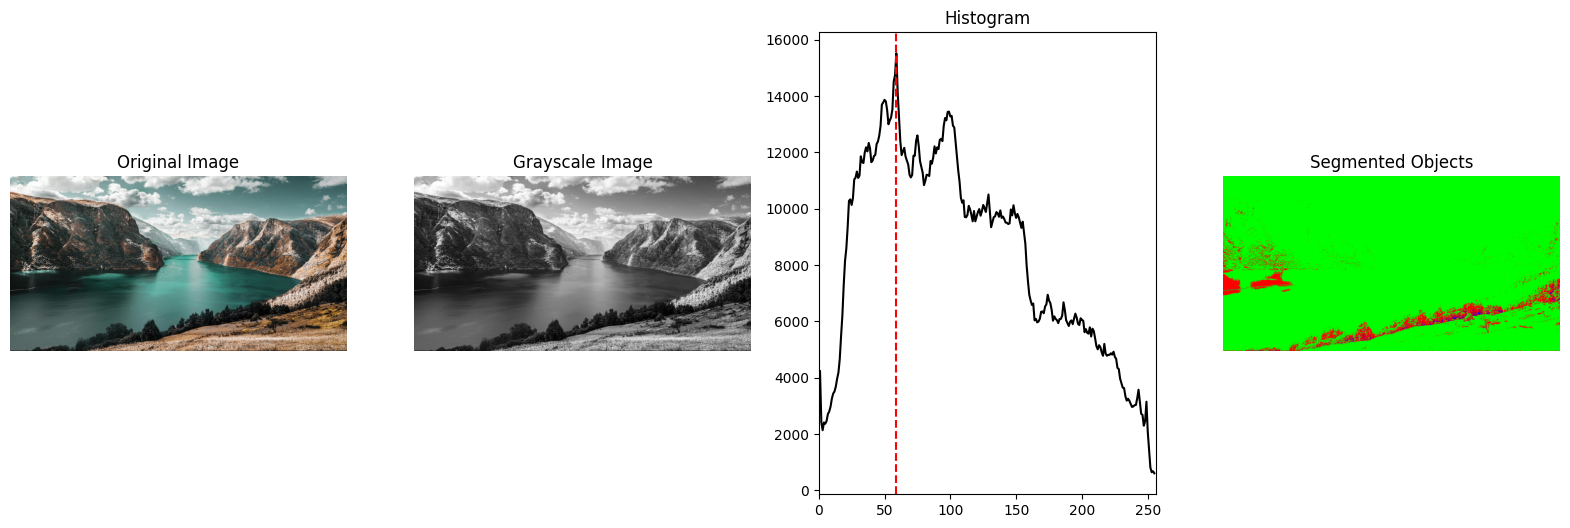

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
from scipy.signal import find_peaks
from skimage import img_as_float, io

def load_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

image_url = "https://images.unsplash.com/photo-1549558549-415fe4c37b60?q=80&w=2019&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"
image = load_image_from_url(image_url)

gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

histogram, bins = np.histogram(gray_image, bins=256, range=[0, 256])

peaks, _ = find_peaks(histogram, prominence=100)

ranges = [(bins[peaks[i]], bins[peaks[i+1]]) for i in range(len(peaks)-1)]

highest_peak_index = np.argmax(histogram)
highest_peak_value = histogram[highest_peak_index]

segmented_img = np.zeros((gray_image.shape[0], gray_image.shape[1], 3))

region_3 = (gray_image <= ranges[0][0])
region_1 = (gray_image > ranges[0][0]) & (gray_image <= ranges[1][0])
region_2 = (gray_image > ranges[1][0])

segmented_img[region_1] = (1, 0, 0)
segmented_img[region_2] = (0, 1, 0)
segmented_img[region_3] = (0, 0, 1)

fig, axes = plt.subplots(1, 4, figsize=(20, 6))

axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(gray_image, cmap='gray')
axes[1].set_title('Grayscale Image')
axes[1].axis('off')

axes[2].plot(bins[:-1], histogram, color='black')
axes[2].axvline(x=bins[highest_peak_index], color='red', linestyle='--')
axes[2].set_title('Histogram')
axes[2].set_xlim([0, 256])

axes[3].imshow(segmented_img)
axes[3].set_title('Segmented Objects')
axes[3].axis('off')

plt.show()


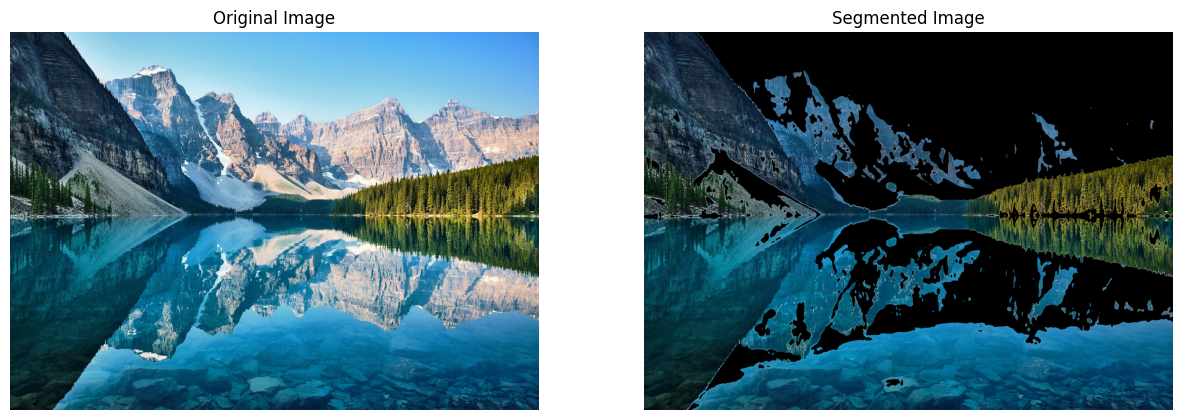

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

def load_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

image_url = "https://images.unsplash.com/photo-1503614472-8c93d56e92ce?q=80&w=2011&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"
image = load_image_from_url(image_url)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred_image = cv2.GaussianBlur(gray_image, (15, 25), 0)
_, mask = cv2.threshold(blurred_image, 120, 255, cv2.THRESH_BINARY_INV)
segmented_image = cv2.bitwise_and(image_rgb, image_rgb, mask=mask)

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

axes[0].imshow(image_rgb)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(segmented_image)
axes[1].set_title('Segmented Image')
axes[1].axis('off')

plt.show()
